In [3]:
! pip install seaborn

     ---------------------------------------- 0.0/165.9 kB ? eta -:--:--
     --------------------- ----------------- 92.2/165.9 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 165.9/165.9 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------------ --------------------- 133.1/294.9 kB 4.0 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
    --------------------------------------- 0.2/8.0 MB 5.9 MB/s eta 0:00:02
   -- ------------------------------------- 0.4/8.0 MB 5.1 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/8.0 MB 5.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.0 MB 4.9 MB/s eta 0:00:02
   ---- ----------------------------------- 0.8/8.0 MB 4.5 MB/s eta 0:00:02
   ----

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

### Defining Train and Test Paths

In [5]:
BASE_DIR = "Alzheimer_Dataset/"
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
DIM = (IMG_SIZE, IMG_SIZE)

### Generating Data using DataGenerator

In [6]:
datagen = IDG(
    rescale = 1./255, 
    brightness_range=[0.8, 1.2], 
    zoom_range=[.99, 1.01], 
    data_format="channels_last", 
    fill_mode='constant',
    horizontal_flip=True
)

train_data_gen = datagen.flow_from_directory(directory=TRAIN_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


### Retrieving features and labels

In [7]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


### Splitting Train Test Data

In [8]:
#Splitting the data into train, test, and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, 
                                                                  train_labels, 
                                                                  test_size = 0.2, 
                                                                  random_state=42)

In [9]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*[IMG_SIZE,IMG_SIZE], 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

### Defining MyCallback class

It says that when on the end of an epoch, the val accuracy crosses 0.99 stop the training.

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
CALLBACKS = [my_callback]

In [11]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]



model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

# model.summary()

In [12]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)
model.save('../models/alzheimer_model.h5')

Epoch 1/50
128/128 [==============================] - 94s 717ms/step - loss: 1.6556 - acc: 0.3340 - auc: 0.5971 - val_loss: 3.0566 - val_acc: 0.3424 - val_auc: 0.4446
Epoch 2/50
128/128 [==============================] - 90s 706ms/step - loss: 1.2698 - acc: 0.4490 - auc: 0.7247 - val_loss: 1.2467 - val_acc: 0.3424 - val_auc: 0.7019
Epoch 3/50
128/128 [==============================] - 182s 1s/step - loss: 1.0940 - acc: 0.5010 - auc: 0.7868 - val_loss: 1.0797 - val_acc: 0.4966 - val_auc: 0.8048
Epoch 4/50
128/128 [==============================] - 90s 696ms/step - loss: 1.0138 - acc: 0.5198 - auc: 0.8098 - val_loss: 1.0088 - val_acc: 0.5122 - val_auc: 0.8180
Epoch 5/50
128/128 [==============================] - 89s 699ms/step - loss: 0.9769 - acc: 0.5212 - auc: 0.8172 - val_loss: 1.1497 - val_acc: 0.5024 - val_auc: 0.8112
Epoch 6/50
128/128 [==============================] - 89s 699ms/step - loss: 0.9284 - acc: 0.5437 - auc: 0.8331 - val_loss: 1.7636 - val_acc: 0.4888 - val_auc: 0.7932


### Plot model performance


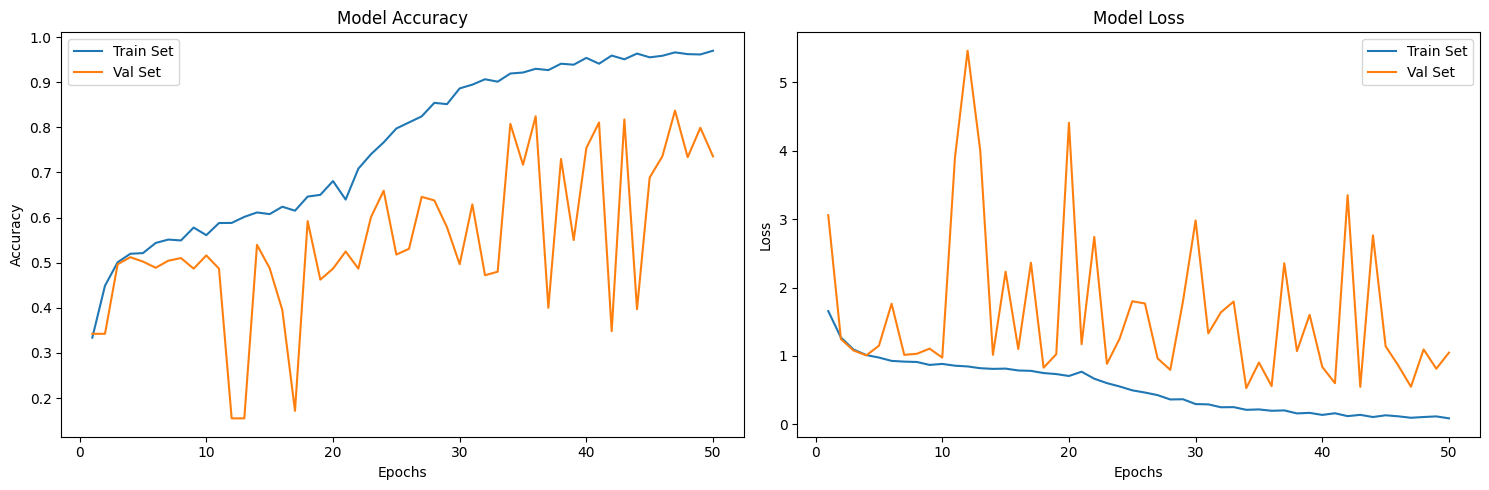

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Predicting the test data

In [15]:
pred_labels = model.predict(val_data)

33/33 [==============================] - 4s 101ms/step


### Plot the confusion matrix to understand the classification in detail

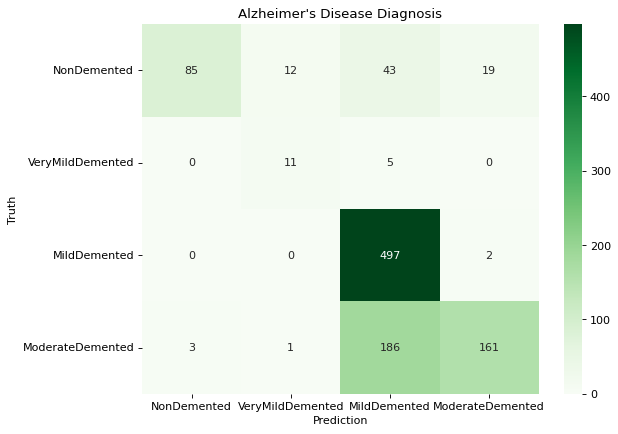

In [17]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(val_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)